In [2]:
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()
dataframe.shape

(3111, 236)

In [3]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns.difference(['year']).tolist() #we don't want year to be a feature in our prediction model
#we want to limit our feature set to columns without any data leaks, since in real prediction we wouldn't know those values.
data_leak_list = ["co2", "ghg", "greenhouse_gas",  "change"]
possible_data_leak_list = ["nitrous_oxide", "methane", "ch4", "n2o"]
to_exclude = data_leak_list + possible_data_leak_list

def is_data_leak(s, to_exclude):
    for data_leak in to_exclude:
        if data_leak in s:
            return True

    return False

feature_list = []
for x in numeric_cols:
    is_leak = is_data_leak(x, to_exclude)
    if not is_leak:
        feature_list.append(x)

print(feature_list)

['agricultural_land_area_in_hectares', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_per_capita', 'coal_consumption', 'coal_elec_per_capita', 'coal_electricity', 'coal_prod_per_capita', 'coal_production', 'coal_share_elec', 'coal_share_energy', 'cropland_area_in_hectares', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_per_capita', 'energy_per_gdp', 'exports_of_goods_and_services_(%_of_gdp)_[ne.exp.gnfs.zs]', 'forest_land_area_in_hectares', 'fossil_elec_per_capita', 'fossil_electricity', 'fossil_energy_per_capita', 'fossil_fuel_consumption', 'fossil_share_elec', 'fossil_share_energy', 'gas_consumption', 'gas_elec_per_capita', 'gas_electricity', 'gas_energy_per_capita', 'gas_prod_per_capita', 'gas_production', 'gas_share_elec', 'gas_share_energy', 'gdp', 'hydro_consumption', 'hydro_elec_per_capita', 'hydro_electricit

In [4]:
#checking correlations between various features and co2 data
dataframe[feature_list + ['co2']].corr()['co2'].sort_values(ascending=False) #Reduced feature list to 97, need to check if any of these are unrelated. 

co2                                                                           1.000000
fossil_fuel_consumption                                                       0.992039
fossil_electricity                                                            0.990393
primary_energy_consumption                                                    0.987325
electricity_generation                                                        0.979713
                                                                                ...   
population_ages_10-14,_female_(%_of_female_population)_[sp.pop.1014.fe.5y]   -0.162488
nuclear_share_energy                                                         -0.164459
population_ages_05-09,_female_(%_of_female_population)_[sp.pop.0509.fe.5y]   -0.165571
imports_of_goods_and_services_(%_of_gdp)_[ne.imp.gnfs.zs]                    -0.170947
oil_share_energy                                                             -0.174311
Name: co2, Length: 130, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ('std_scalar', StandardScaler())])
# test if I can hand-pick a few features avoiding most of the repeats.
X = dataframe[feature_list]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Training Model for features with no data leaks

In [7]:
X_train_no_data_leaks = data_pipeline.fit_transform(X_train)
X_test_no_data_leaks = data_pipeline.transform(X_test)
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models_no_data_leaks = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train_no_data_leaks, y_train) for x in models_no_data_leaks ] #train features with data leak features removed

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def adjusted_r2(r2_score, sample_size, num_features):
    return 1-(1-r2_score)*(sample_size-1)/(sample_size-num_features-1)

## Checking scores for models with data leak features removed.

In [9]:
training_predictions = [m.predict(X_train_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Train data scores
 LinearRegression: Mean Squared Error: 270.5519618700469, R2_score 0.9994824073466382, Adjusted R2 score: 0.9994540912091133, Mean absolute Percentage Error: 236.687847478641%
 Ridge: Mean Squared Error: 294.0065473823152, R2_score 0.9994375364055262, Adjusted R2 score: 0.9994067654964138, Mean absolute Percentage Error: 192.2103830586945%
 Lasso: Mean Squared Error: 454.2921464663216, R2_score 0.9991308942065485, Adjusted R2 score: 0.999083347706398, Mean absolute Percentage Error: 120.60243710413694%
 DecisionTreeRegressor: Mean Squared Error: 9.289051178716572e-37, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 1.945775229167136e-17%
 RandomForestRegressor: Mean Squared Error: 345.23445734919574, R2_score 0.9993395323486987, Adjusted R2 score: 0.9993033998944926, Mean absolute Percentage Error: 3.0352072616241803%
 SGDRegressor: Mean Squared Error: 1356951130095.4995, R2_score -2595980.6778033897, Adjusted R2 score: -2738000.03167813, Mean ab

[None, None, None, None, None, None]

In [10]:
predictions = [m.predict(X_test_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_test, y_) for y_ in predictions]
r2_scores = [r2_score(y_test, y_) for y_ in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Test data scores
 LinearRegression: Mean Squared Error: 372.5310463953729, R2_score 0.9996309287912667, Adjusted R2 score: 0.9995343564060201, Mean absolute Percentage Error: 283.798014731885%
 Ridge: Mean Squared Error: 309.38618070172447, R2_score 0.9996934872065514, Adjusted R2 score: 0.9996132840618154, Mean absolute Percentage Error: 216.89526550829217%
 Lasso: Mean Squared Error: 460.19753801310156, R2_score 0.999544076491734, Adjusted R2 score: 0.9994247780483947, Mean absolute Percentage Error: 128.77722272209903%
 DecisionTreeRegressor: Mean Squared Error: 3359.537646027291, R2_score 0.9966716636591723, Adjusted R2 score: 0.9958007602353045, Mean absolute Percentage Error: 10.249781197864824%
 RandomForestRegressor: Mean Squared Error: 913.3723630113097, R2_score 0.9990951104738733, Adjusted R2 score: 0.9988583341069964, Mean absolute Percentage Error: 7.615544206718259%
 SGDRegressor: Mean Squared Error: 2735886936267.5127, R2_score -2710476.712652832, Adjusted R2 score: -341

[None, None, None, None, None, None]

In [11]:
#random forest has the lowest accuracy error and a decent r2 score.
random_forest_preds = predictions[4]

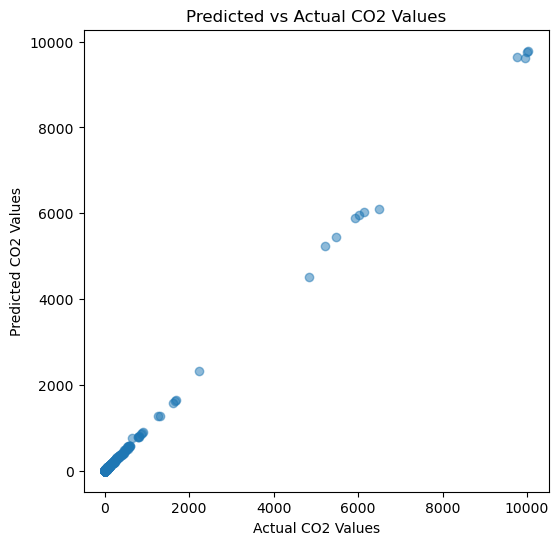

In [12]:
#Seems like Lasso performs the best which is to be expected.

import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, random_forest_preds, alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.show()

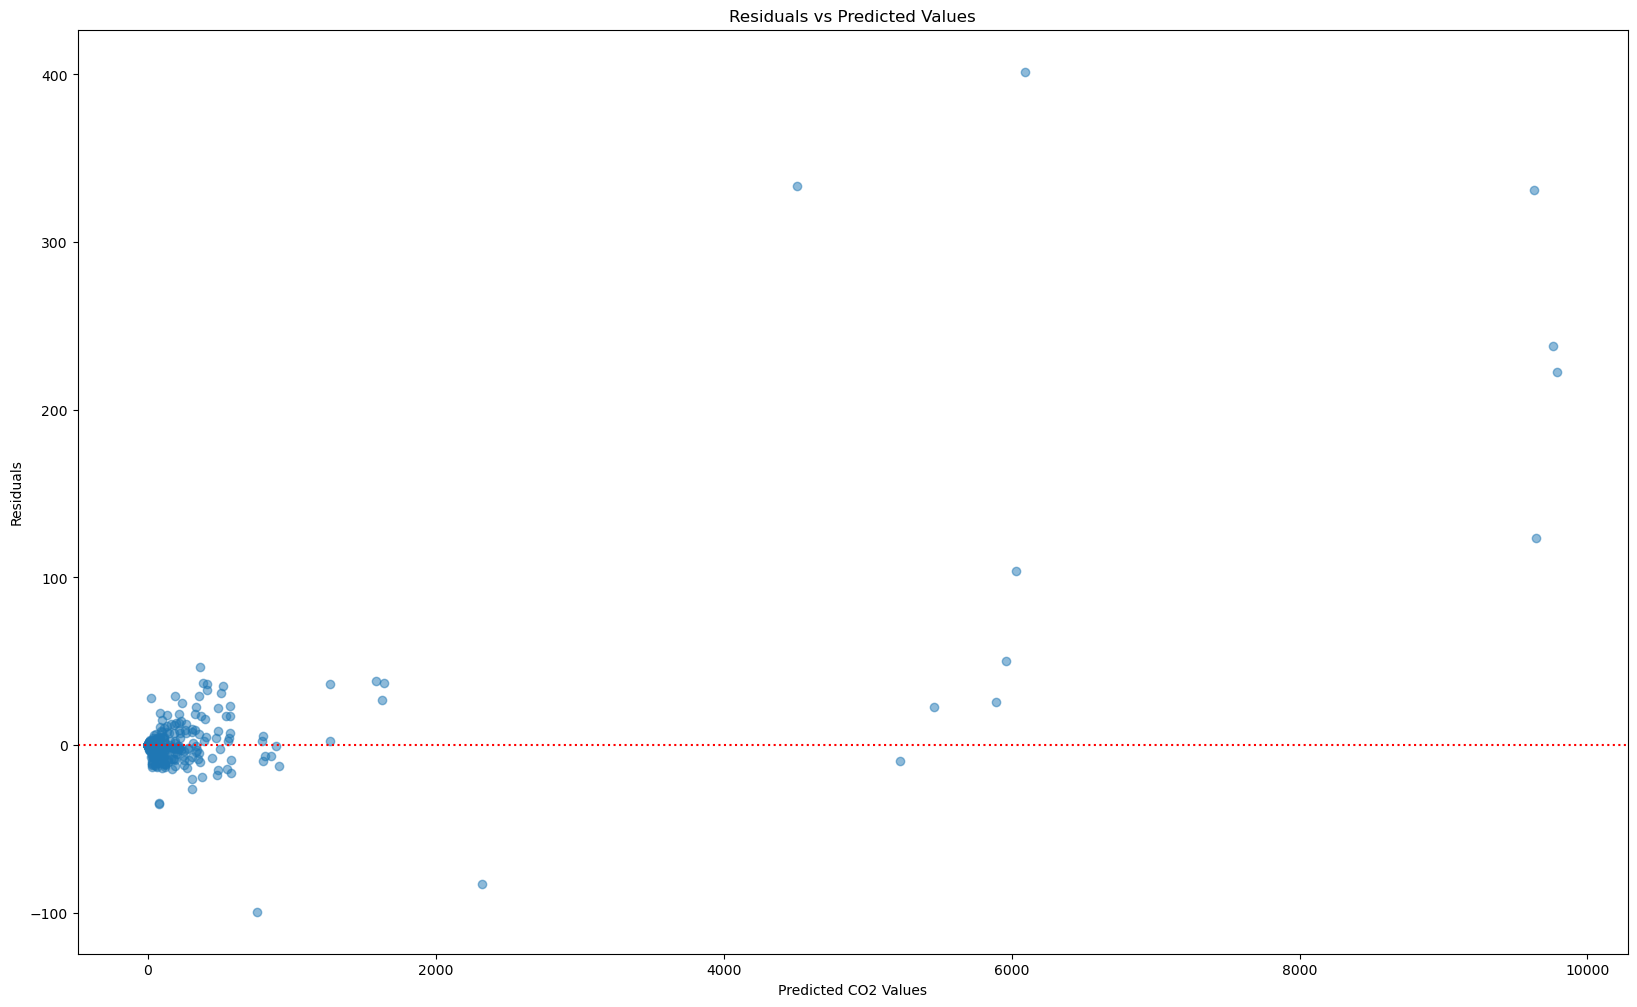

In [13]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = random_forest_preds

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(20, 12))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle=':')  # Adds a horizontal line at zero
plt.show()

<Axes: >

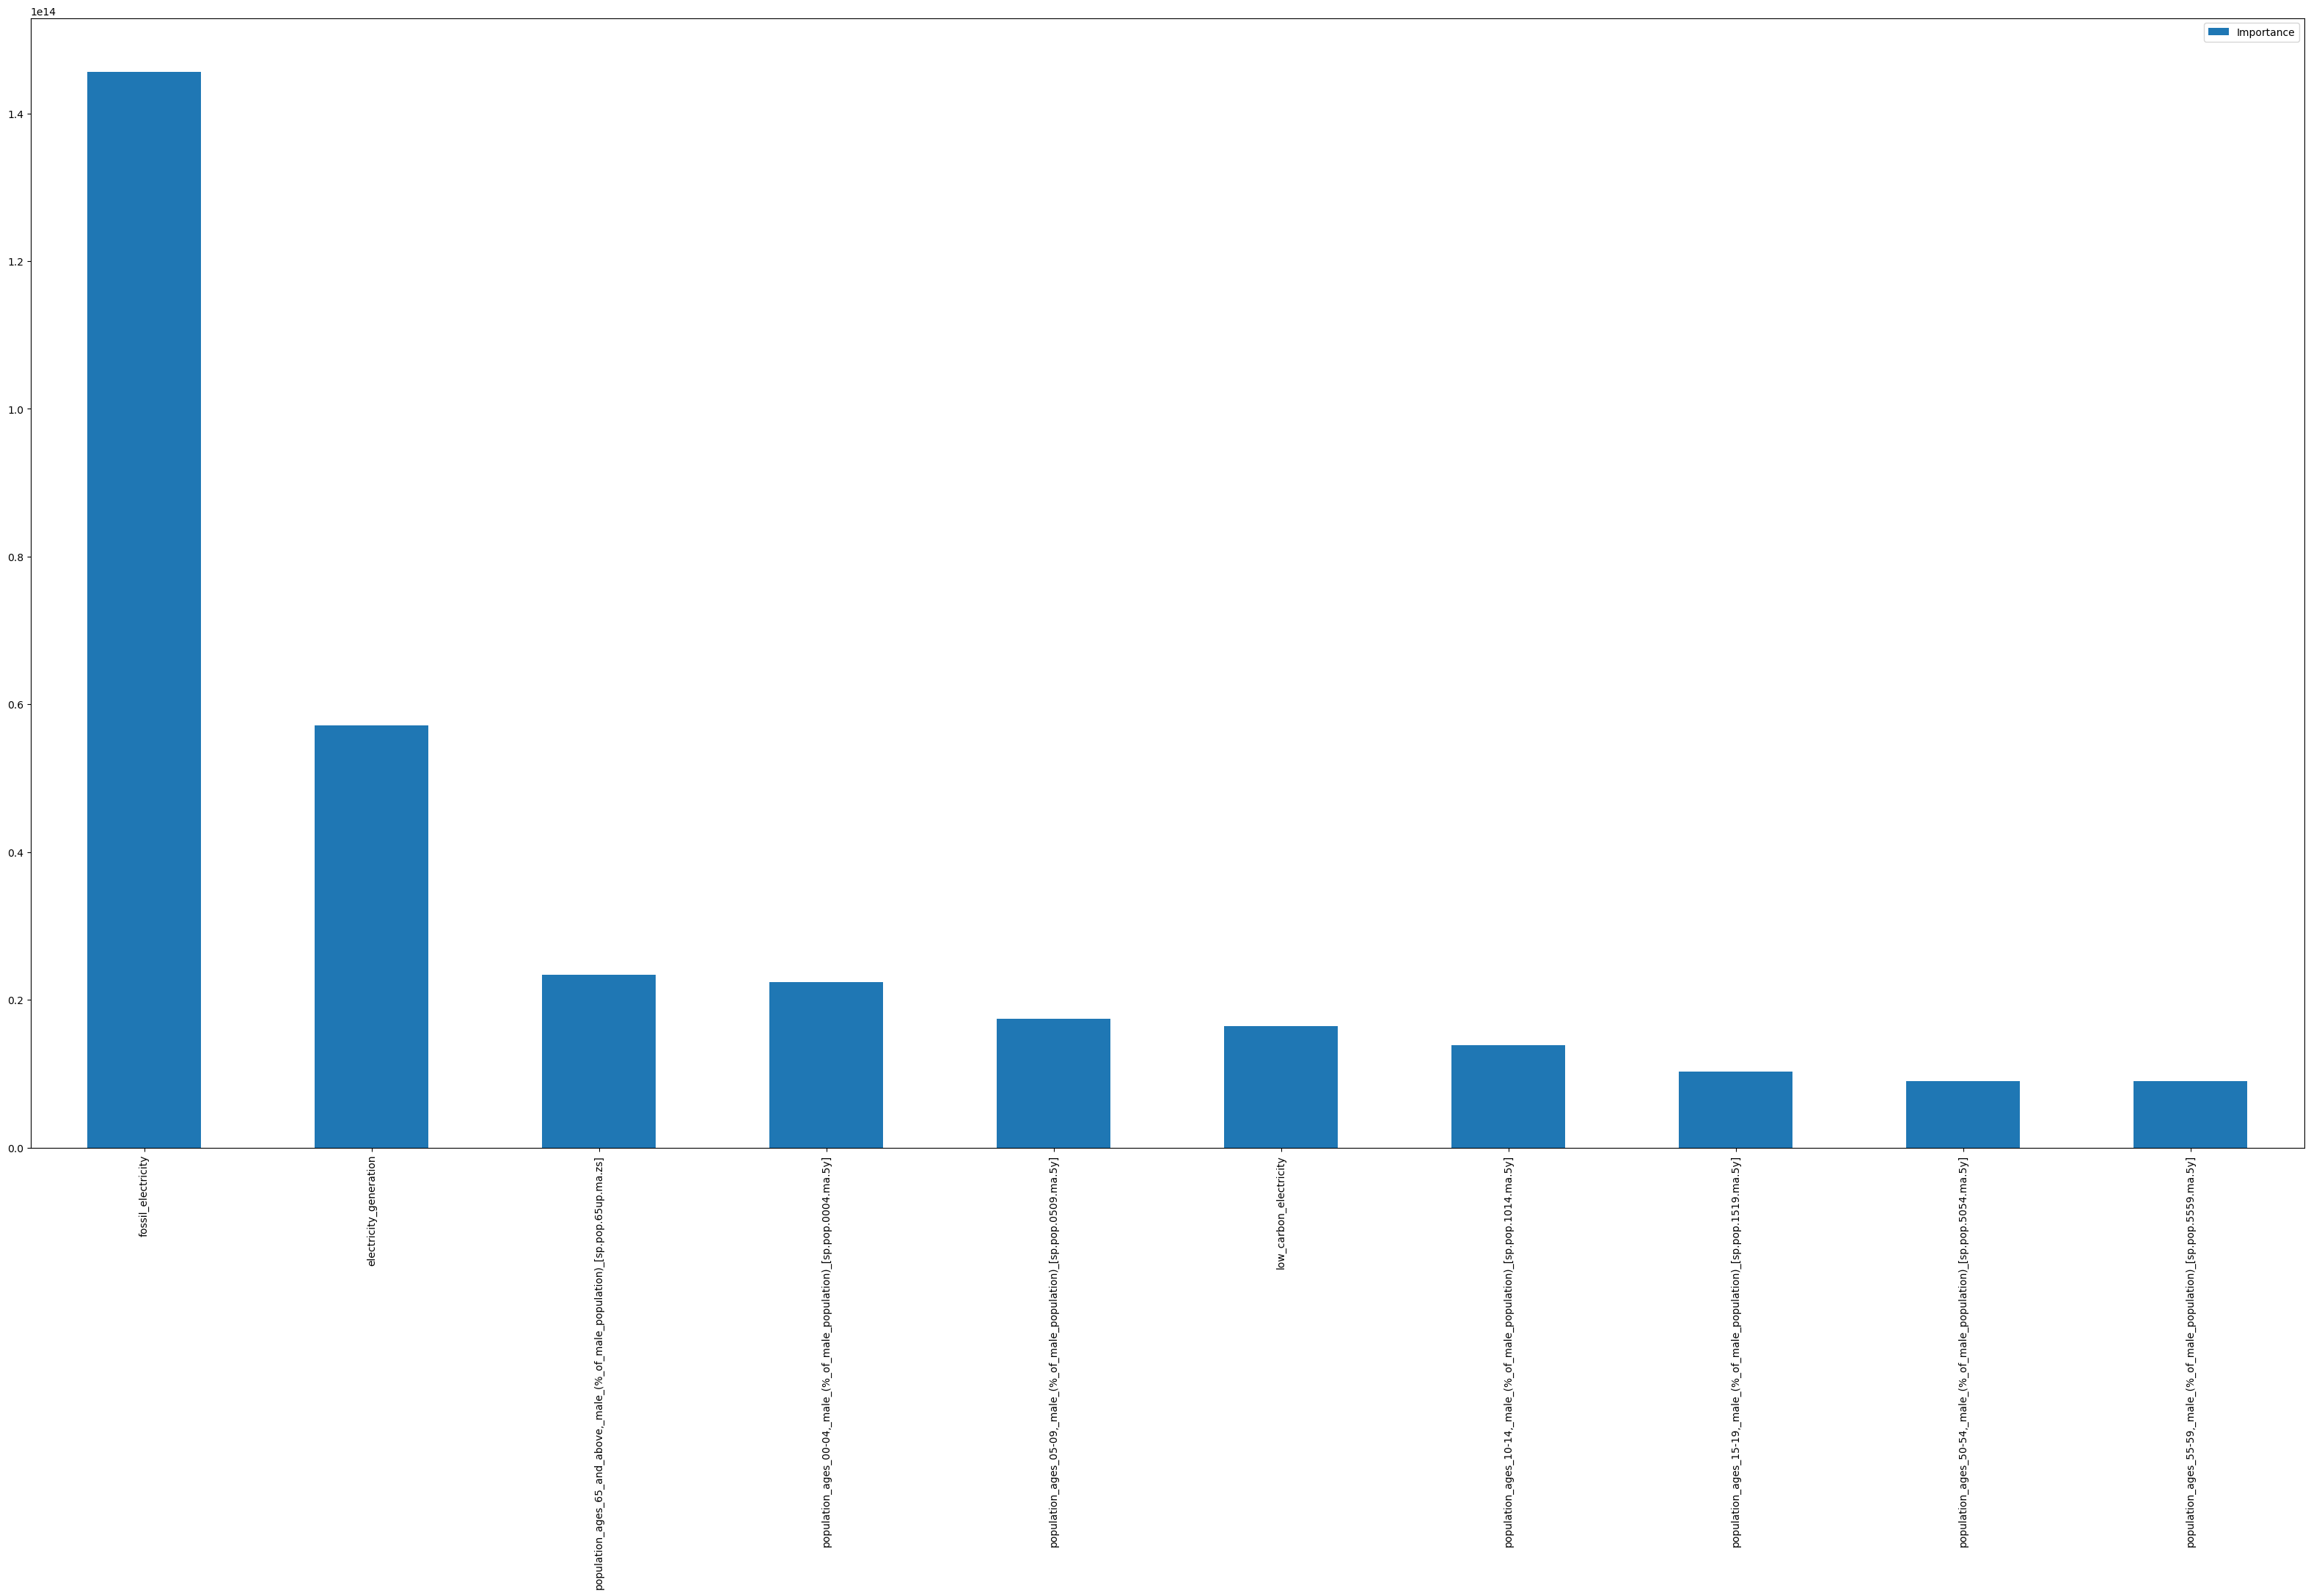

In [16]:
import pandas as pd
model = models_no_data_leaks[0]
importance_df = pd.DataFrame(model.coef_, index=feature_list, columns=["Importance"])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df.head(10).plot(kind='bar', figsize=(40,20))

In [17]:
selected_features = importance_df.head(10).index.tolist()
print(selected_features)

X = dataframe[selected_features]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = data_pipeline.fit_transform(X_train)
X_test = data_pipeline.transform(X_test)

['fossil_electricity', 'electricity_generation', 'population_ages_65_and_above,_male_(%_of_male_population)_[sp.pop.65up.ma.zs]', 'population_ages_00-04,_male_(%_of_male_population)_[sp.pop.0004.ma.5y]', 'population_ages_05-09,_male_(%_of_male_population)_[sp.pop.0509.ma.5y]', 'low_carbon_electricity', 'population_ages_10-14,_male_(%_of_male_population)_[sp.pop.1014.ma.5y]', 'population_ages_15-19,_male_(%_of_male_population)_[sp.pop.1519.ma.5y]', 'population_ages_50-54,_male_(%_of_male_population)_[sp.pop.5054.ma.5y]', 'population_ages_55-59,_male_(%_of_male_population)_[sp.pop.5559.ma.5y]']


In [18]:
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train, y_train) for x in models ]

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [19]:
training_predictions = [m.predict(X_train) for m in models]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models)]

Train data scores
 LinearRegression: Mean Squared Error: 11335.885038361454, R2_score 0.9783133311078043, Adjusted R2 score: 0.9782257789524058, Mean absolute Percentage Error: 499.765361105764%
 Ridge: Mean Squared Error: 11337.402455205816, R2_score 0.9783104281393493, Adjusted R2 score: 0.9782228642642559, Mean absolute Percentage Error: 485.52239228192747%
 Lasso: Mean Squared Error: 11399.715401641763, R2_score 0.9781912173117447, Adjusted R2 score: 0.9781031721656477, Mean absolute Percentage Error: 315.04159985209577%
 DecisionTreeRegressor: Mean Squared Error: 0.001185036696141479, R2_score 0.9999999977329076, Adjusted R2 score: 0.999999997723755, Mean absolute Percentage Error: 0.2549798765084273%
 RandomForestRegressor: Mean Squared Error: 1031.3566143451687, R2_score 0.998026912823358, Adjusted R2 score: 0.9980189471908322, Mean absolute Percentage Error: 6.892609185789228%
 SGDRegressor: Mean Squared Error: 11642.382506161797, R2_score 0.9777269711475551, Adjusted R2 score:

[None, None, None, None, None, None]

In [20]:
predictions = [m.predict(X_test) for m in models]
mean_sq_errors = [mean_squared_error(y_test, y) for y in predictions]
r2_scores = [r2_score(y_test, y) for y in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100} %") for i, model in enumerate(models)]

Train data scores
 LinearRegression: Mean Squared Error: 12491.59826926418, R2_score 0.9876244159598039, Adjusted R2 score: 0.9874222005343105, Mean absolute Percentage Error: 576.8469611609719 %
 Ridge: Mean Squared Error: 12486.464169693661, R2_score 0.987629502377037, Adjusted R2 score: 0.9874273700629362, Mean absolute Percentage Error: 558.4683087010926 %
 Lasso: Mean Squared Error: 12502.415951074838, R2_score 0.9876136987459229, Adjusted R2 score: 0.9874113082025556, Mean absolute Percentage Error: 323.9355673346191 %
 DecisionTreeRegressor: Mean Squared Error: 2937.08195946544, R2_score 0.9970901958389309, Adjusted R2 score: 0.9970426500193056, Mean absolute Percentage Error: 18.70744058991893 %
 RandomForestRegressor: Mean Squared Error: 3530.7556833527665, R2_score 0.9965020357889475, Adjusted R2 score: 0.9964448795109891, Mean absolute Percentage Error: 15.850565026597943 %
 SGDRegressor: Mean Squared Error: 13409.19052114907, R2_score 0.9867153457365183, Adjusted R2 score: 

[None, None, None, None, None, None]